<a href="https://colab.research.google.com/github/wilberquito/AMLProject/blob/main/notebooks/EfficientNet_V2_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet_V2_S

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

import zipfile
from pathlib import Path
import torch
import matplotlib.pyplot as plt

In [ ]:
if IN_COLAB:
    ! pip install torchvision
    ! pip install torchinfo

    from google.colab import drive
    drive.mount('/content/drive')

    !rm -rf data
    data_path = Path('/content/drive/MyDrive/AML/dataset_CIFAR10.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall("data")

    !rm -rf modular
    data_path = Path('/content/drive/MyDrive/AML/modular.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall(".")

    !rm -rf trained
    !cp -rf /content/drive/MyDrive/AML/trained ./trained

## Show device available

In [ ]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

## Show model arquitecture

In [ ]:
from torchinfo import summary
import modular.models as models
from prettytable import PrettyTable

In [ ]:
net = models.AMLEfficientNet_V2_S(10)

In [ ]:
batch_size = 16
img_size = 232
summary(model=net, 
        input_size=(32, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
AMLEfficientNet_V2_S (AMLEfficientNet_V2_S)                       [32, 3, 232, 232]    [32, 10]             --                   Partial
├─EfficientNet (net)                                              [32, 3, 232, 232]    [32, 1280]           --                   False
│    └─Sequential (features)                                      [32, 3, 232, 232]    [32, 1280, 8, 8]     --                   False
│    │    └─Conv2dNormActivation (0)                              [32, 3, 232, 232]    [32, 24, 116, 116]   (696)                False
│    │    └─Sequential (1)                                        [32, 24, 116, 116]   [32, 24, 116, 116]   (10,464)             False
│    │    └─Sequential (2)                                        [32, 24, 116, 116]   [32, 48, 58, 58]     (303,552)            False
│    │    └─Sequential (3)                       

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
_ = count_parameters(net)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| classifier.1.weight |   12800    |
|  classifier.1.bias  |     10     |
+---------------------+------------+
Total Trainable Params: 12810


## Fine tunning

In [ ]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Model
net = models.AMLEfficientNet_V2_S(10)
# Let base train
net.unfreeze_base()

train_transforms, validate_transforms = net.transforms, net.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.Adam(params=net.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 2

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('finetune.efficientnet_v2_s.pth')

# Mini batch
batch_size=30

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
results = train(model=net,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.1389 | train_acc: 0.5976 | test_loss: 0.7183 | test_acc: 0.7524


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.8175 | train_acc: 0.7162 | test_loss: 0.6188 | test_acc: 0.7875


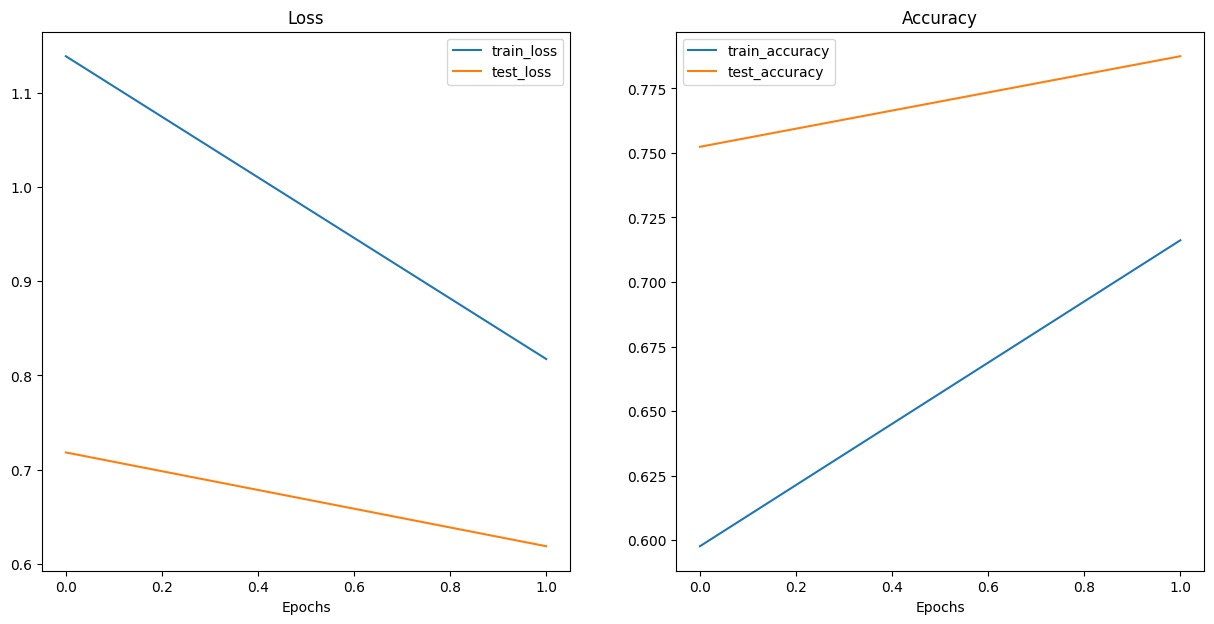

In [ ]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)

In [ ]:
if IN_COLAB:
  from google.colab import files
  files.download('finetune.efficientnet_v2_s.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training find tunning EfficientNet_V2_S

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

import zipfile
from pathlib import Path
import torch
import matplotlib.pyplot as plt

In [2]:
if IN_COLAB:
    ! pip install torchvision
    ! pip install torchinfo
    
    from google.colab import drive
    drive.mount('/content/drive')

    !rm -rf data
    data_path = Path('/content/drive/MyDrive/AML/dataset_CIFAR10.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall("data")

    !rm -rf modular
    data_path = Path('/content/drive/MyDrive/AML/modular.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall(".")

    !rm -rf trained
    !cp -rf /content/drive/MyDrive/AML/trained ./trained

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import torch
from pathlib import Path

saved_data = torch.load(Path('trained/finetune.efficientnet_v2_s.pth'))
saved_data.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch', 'optimizer', 'model'])

In [3]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Model
net = models.AMLEfficientNet_V2_S(out_dim=10)
# Recover state dict
state_dict = saved_data['model']
# Load saved state dict into the model
net.load_state_dict(state_dict)
# Freeze base
net.freeze_base()

train_transforms, validate_transforms = net.transforms, net.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.Adam(params=net.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 10

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('efficientnet_v2_s.pth')

# Mini batch
batch_size=400

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
results = train(model=net,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 0.6188 | train_acc: 0.7832 | test_loss: 0.5058 | test_acc: 0.8267


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.5445 | train_acc: 0.8127 | test_loss: 0.4993 | test_acc: 0.8298


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.5989 | train_acc: 0.7899 | test_loss: 0.4874 | test_acc: 0.8342


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4 | train_loss: 0.5969 | train_acc: 0.7933 | test_loss: 0.4811 | test_acc: 0.8353


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5 | train_loss: 0.5915 | train_acc: 0.7938 | test_loss: 0.4738 | test_acc: 0.8367


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 6 | train_loss: 0.5924 | train_acc: 0.7930 | test_loss: 0.4739 | test_acc: 0.8359


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 7 | train_loss: 0.5877 | train_acc: 0.7940 | test_loss: 0.4727 | test_acc: 0.8364


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 8 | train_loss: 0.5841 | train_acc: 0.7948 | test_loss: 0.4749 | test_acc: 0.8356


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 9 | train_loss: 0.5811 | train_acc: 0.7953 | test_loss: 0.4700 | test_acc: 0.8391


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 10 | train_loss: 0.5762 | train_acc: 0.7977 | test_loss: 0.4693 | test_acc: 0.8370


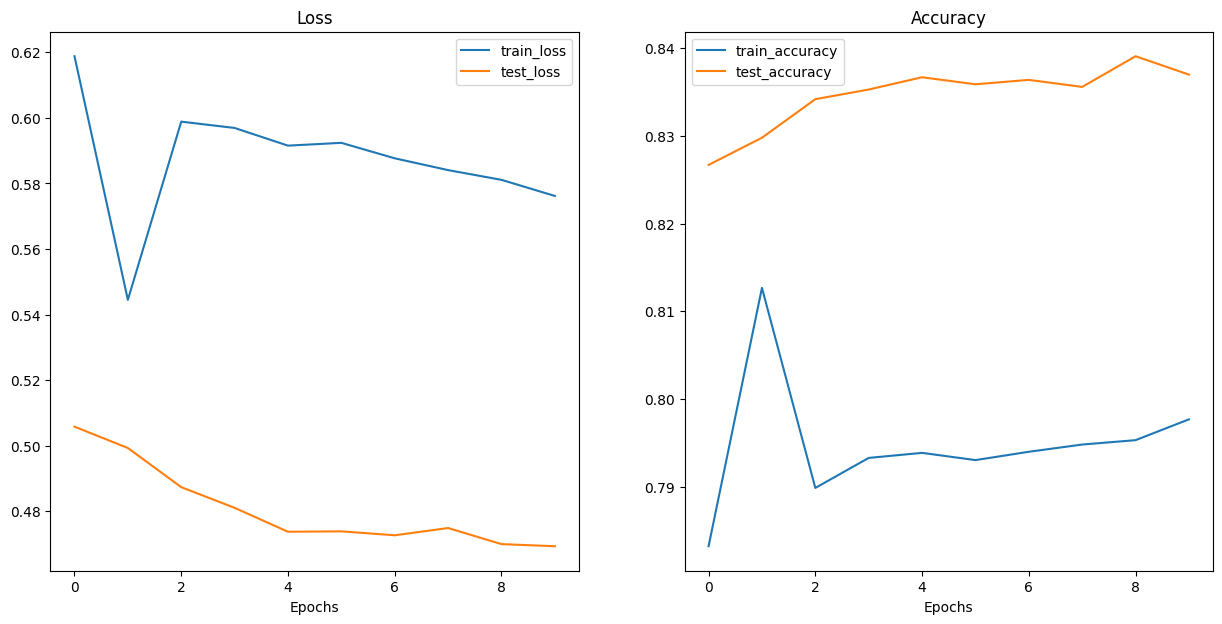

In [5]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)

In [6]:
if IN_COLAB:
  from google.colab import files
  files.download('efficientnet_v2_s.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>